In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

Dados do IBGE: https://sidra.ibge.gov.br/tabela/5919  
https://sidra.ibge.gov.br/pesquisa/pnadca/tabelas  
https://sidra.ibge.gov.br/tabela/7128

In [2]:
PATH_DADOS = '../dados/escolaridade/'
PATH_ESCOL = PATH_DADOS + 'escolaridade_por_estados.csv'

Lendo e processando dados de escolaridade por estado

In [3]:
df = pd.read_csv(PATH_ESCOL, encoding='UTF-8', sep=';')
pd.set_option('display.max_columns', None)
df = df.drop([0,1])
df = df.iloc[0:224, :]
df = df.rename(columns={'Ano x Sexo':'qtd', 'Brasil e Unidade da Federação':'estados', 'Nível de instrução':'escolaridade'})
df['estados'] = df['estados'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.lower()
df.qtd = df.qtd.astype(int)
df.qtd = df.qtd.apply(lambda x : x * 1000)
df.head()

,estados,escolaridade,qtd
2,brasil,Total,170864000
3,brasil,Sem instrução,8960000
4,brasil,Ensino fundamental incompleto ou equivalente,51248000
5,brasil,Ensino fundamental completo ou equivalente,15531000
6,brasil,Ensino médio incompleto ou equivalente,13450000


Na base SIVEP não há diferenciação de ensino completo para incompleto, então se fez necessário juntar os dois para a normalização

In [4]:
escolaridade_dict = {'Total':'total','Sem instrução':'sem', 'Ensino fundamental incompleto ou equivalente':'fund_inc',
                    'Ensino fundamental completo ou equivalente':'fund_comp', 'Ensino médio incompleto ou equivalente':'med_inc',
                    'Ensino médio completo ou equivalente':'med_com', 'Ensino superior incompleto ou equivalente':'sup_inc',
                    'Superior completo':'sup_com'}
#Juntando incompleto com completo
escolaridade_dict = {'Total':'total','Sem instrução':'sem', 'Ensino fundamental incompleto ou equivalente':'fund',
                    'Ensino fundamental completo ou equivalente':'fund', 'Ensino médio incompleto ou equivalente':'med',
                    'Ensino médio completo ou equivalente':'med', 'Ensino superior incompleto ou equivalente':'sup',
                    'Superior completo':'sup'}
df.escolaridade = df.escolaridade.replace(escolaridade_dict)
df.head()

,estados,escolaridade,qtd
2,brasil,total,170864000
3,brasil,sem,8960000
4,brasil,fund,51248000
5,brasil,fund,15531000
6,brasil,med,13450000


Lendo e filtrando os dados pre-processados do SIVEP

In [5]:
PATH_DADOS = '../dados/processados/'
PATH_SIVEP = PATH_DADOS + 'influd_processado.csv'
df_covid = pd.read_csv(PATH_SIVEP, encoding='UTF-8')
df_covid.head()

,DT_NOTIFIC,SEM_NOT,SG_UF_NOT,ID_MUNICIP,CO_MUN_NOT,CS_SEXO,NU_IDADE_N,CS_RACA,CS_ESCOL_N,CLASSI_FIN
0,2020-03-04,10,SP,SAO JOSE DOS CAMPOS,354990,M,74,1.0,9.0,5.0
1,2020-03-03,10,SP,AURIFLAMA,350420,F,49,4.0,9.0,5.0
2,2020-03-06,10,DF,BRASILIA,530010,F,52,4.0,9.0,5.0
3,2020-03-04,10,PR,CURITIBA,410690,M,1,9.0,5.0,5.0
4,2020-03-05,10,PE,RECIFE,261160,M,71,4.0,9.0,5.0


In [6]:
df_covid['CS_ESCOL_N'].dropna().unique()

array([9., 5., 4., 3., 1., 0., 2.])

In [7]:
df_covid = df_covid[df_covid['NU_IDADE_N'] >= 14]
df_covid = df_covid[(df_covid['CS_ESCOL_N'] != 9.0) & (df_covid['CS_ESCOL_N'] != 5.0)]
df_covid.CS_ESCOL_N = df_covid['CS_ESCOL_N'].dropna(how='any')
df_covid

,DT_NOTIFIC,SEM_NOT,SG_UF_NOT,ID_MUNICIP,CO_MUN_NOT,CS_SEXO,NU_IDADE_N,CS_RACA,CS_ESCOL_N,CLASSI_FIN
5,2020-03-10,11,RJ,PETROPOLIS,330390,M,65,9.0,NaN,5.0
6,2020-03-06,10,PA,BELEM,150140,M,53,4.0,4.0,5.0
7,2020-03-12,11,SP,SAO PAULO,355030,F,86,NaN,NaN,5.0
8,2020-03-16,12,SP,RIBEIRAO PRETO,354340,M,43,1.0,4.0,5.0
9,2020-03-13,11,RJ,RIO DE JANEIRO,330455,M,65,NaN,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...
117425,2020-06-16,25,SP,CAMPINAS,350950,M,88,4.0,0.0,5.0
117426,2020-06-01,23,AM,MANAUS,130260,M,19,4.0,3.0,5.0
117427,2020-06-16,25,MT,CAMPO NOVO DO PARECIS,510263,M,37,4.0,2.0,5.0
117429,2020-05-18,21,RN,MOSSORO,240800,M,81,4.0,NaN,5.0


Como a base sivep não diferencia completo de incompleto, juntou-se o completo e incompleto somando a quantidade de pessoas de cada um

In [8]:
df = df.groupby(['estados', 'escolaridade']).sum()

In [9]:
df_estados = pd.read_csv('../dados/processados/estados_sigla.csv')
df_estados = df_estados.set_index('SIGLA')

In [10]:
dict_escol = {0.0:'sem', 1.0:'fund', 2.0:'fund', 3.0:'med', 4.0:'sup'}
df_covid.CS_ESCOL_N = df_covid.CS_ESCOL_N.replace(dict_escol)
df_escol = df_covid.groupby(['CS_ESCOL_N', 'SG_UF_NOT']).size().reset_index(name='qtd')
df_escol

,CS_ESCOL_N,SG_UF_NOT,qtd
0,fund,AC,15
1,fund,AL,19
2,fund,AM,1299
3,fund,AP,23
4,fund,BA,165
...,...,...,...
103,sup,RS,168
104,sup,SC,111
105,sup,SE,19
106,sup,SP,2943


Na normalição foi feita uma taxa de 100 mil pessoas

In [11]:
def normalizar_por_estados(row):
    escol = row[0]
    estado = df_estados.loc[row[1]].estado_normalizado
    qtd_casos = row[2]
    qtd_total = df.loc[estado, escol].qtd
    normalizado = (qtd_casos / qtd_total) * 100000
    return normalizado

df_escol['taxa'] = df_escol.apply(normalizar_por_estados, axis=1)
df_escol

,CS_ESCOL_N,SG_UF_NOT,qtd,taxa
0,fund,AC,15,5.813953
1,fund,AL,19,1.597981
2,fund,AM,1299,118.956044
3,fund,AP,23,11.057692
4,fund,BA,165,3.270565
...,...,...,...,...
103,sup,RS,168,8.175182
104,sup,SC,111,8.624709
105,sup,SE,19,7.037037
106,sup,SP,2943,30.200103


Os dados com esse ajuste mostram que a taxa de infecção entre pessoas com ensino fundamental, médio e superior é bem próxima  
Já para pessoas sem escolaridade a taxa é bem mais alta porém a variância também é a alta indicando que pode varias bastante para cada estado

In [31]:
df_escol.to_csv('../dados/processados/escolaridade_estados.csv')
df_escol.drop('qtd', axis=1).groupby(['CS_ESCOL_N']).describe()

taxa                                                       \
           count       mean        std       min       25%        50%   
CS_ESCOL_N                                                              
fund        27.0  19.578505  24.052239  1.597981  6.066018  10.067618   
med         27.0  19.186999  22.390872  3.909266  6.804682  10.810811   
sem         27.0  32.762988  57.525429  2.373887  8.086312  13.775510   
sup         27.0  21.726357  25.792583  0.862069  7.699956  10.569106   

                                   
                  75%         max  
CS_ESCOL_N                         
fund        23.725507  118.956044  
med         21.865697   89.915966  
sem         25.240385  285.384615  
sup         22.730196  119.408503

Analisando a distribuição de cada escolaridade

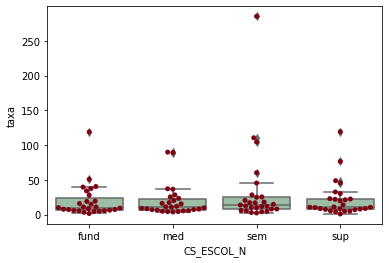

In [25]:
import seaborn as sns
ax = sns.boxplot(x='CS_ESCOL_N', y='taxa', data=df_escol, color='#99c2a2')
ax = sns.swarmplot(x="CS_ESCOL_N", y="taxa", data=df_escol, color='#7d0013')
plt.show()

In [13]:
df_escol[df_escol['taxa'] > 200]

,CS_ESCOL_N,SG_UF_NOT,qtd,taxa
56,sem,AM,371,285.384615


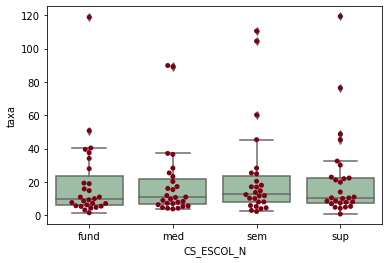

In [27]:
import seaborn as sns
ax = sns.boxplot(x='CS_ESCOL_N', y='taxa', data=df_escol[df_escol['taxa'] < 200], color='#99c2a2')
ax = sns.swarmplot(x="CS_ESCOL_N", y="taxa", data=df_escol[df_escol['taxa'] < 200], color='#7d0013')
plt.show()

### Análise de escolaridade pelo tempo

In [14]:
df_escol_tempo = df_covid.groupby(['SG_UF_NOT', 'DT_NOTIFIC','CS_ESCOL_N']).size().reset_index(name='qtd')
df_escol_tempo

,SG_UF_NOT,DT_NOTIFIC,CS_ESCOL_N,qtd
0,AC,2020-04-06,sem,1
1,AC,2020-04-07,sup,1
2,AC,2020-04-11,fund,1
3,AC,2020-04-14,fund,1
4,AC,2020-04-14,med,1
...,...,...,...,...
5111,TO,2020-06-13,fund,1
5112,TO,2020-06-14,fund,1
5113,TO,2020-06-15,fund,1
5114,TO,2020-06-15,med,1


In [15]:
def normalizar_por_tempo(row):
    escol = row[2]
    estado = df_estados.loc[row[0]].estado_normalizado
    qtd_casos = row[3]
    qtd_total = df.loc[estado, escol].qtd
    normalizado = (qtd_casos / qtd_total) * 100000
    return normalizado

df_escol_tempo['taxa'] = df_escol_tempo.apply(normalizar_por_tempo, axis=1)
df_escol_tempo

,SG_UF_NOT,DT_NOTIFIC,CS_ESCOL_N,qtd,taxa
0,AC,2020-04-06,sem,1,1.612903
1,AC,2020-04-07,sup,1,0.862069
2,AC,2020-04-11,fund,1,0.387597
3,AC,2020-04-14,fund,1,0.387597
4,AC,2020-04-14,med,1,0.462963
...,...,...,...,...,...
5111,TO,2020-06-13,fund,1,0.207039
5112,TO,2020-06-14,fund,1,0.207039
5113,TO,2020-06-15,fund,1,0.207039
5114,TO,2020-06-15,med,1,0.229885


In [16]:
df_escol_tempo['DT_NOTIFIC'] = pd.to_datetime(df_escol_tempo['DT_NOTIFIC'])
aux = df_escol_tempo.drop('qtd', axis=1).groupby(['CS_ESCOL_N', 'DT_NOTIFIC']).mean().reset_index()
aux

,CS_ESCOL_N,DT_NOTIFIC,taxa
0,fund,2020-03-13,0.008053
1,fund,2020-03-15,0.008053
2,fund,2020-03-16,0.032214
3,fund,2020-03-17,0.023868
4,fund,2020-03-18,0.045242
...,...,...,...
378,sup,2020-06-12,0.505879
379,sup,2020-06-13,0.297374
380,sup,2020-06-14,0.355042
381,sup,2020-06-15,0.246092


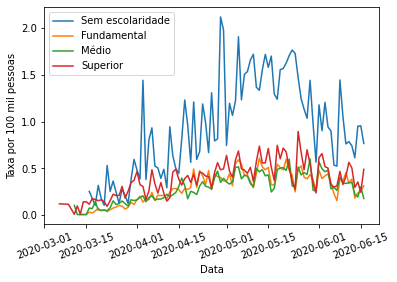

In [17]:
escolaridades = {'sem':'Sem escolaridade','fund':'Fundamental', 'med':'Médio', 'sup':'Superior'}
axis = plt.axes()
for key, value in escolaridades.items():
    plt.plot(aux[aux['CS_ESCOL_N'] == key].DT_NOTIFIC, aux[aux['CS_ESCOL_N'] == key].taxa, label=value)

axis.set_ylabel('Taxa por 100 mil pessoas')
axis.set_xlabel('Data')
plt.xticks(rotation=20)
plt.legend()
plt.savefig('../graficos/escolaridade_normalizado_todas.svg', dpi=300)
plt.savefig('../graficos/escolaridade_normalizado_todas.png', dpi=300)
plt.show()

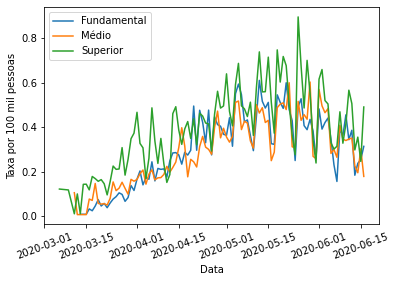

In [18]:
escolaridades = {'fund':'Fundamental', 'med':'Médio', 'sup':'Superior'}
axis = plt.axes()
for key, value in escolaridades.items():
    plt.plot(aux[aux['CS_ESCOL_N'] == key].DT_NOTIFIC, aux[aux['CS_ESCOL_N'] == key].taxa, label=value)

axis.set_ylabel('Taxa por 100 mil pessoas')
axis.set_xlabel('Data')
plt.xticks(rotation=20)
plt.legend()
plt.savefig('../graficos/escolaridade_normalizado_algumas.svg', dpi=300)
plt.savefig('../graficos/escolaridade_normalizado_algumas.png', dpi=300)
plt.show()

In [19]:
dffinal = pd.pivot_table(aux, values='taxa', index=['DT_NOTIFIC'],
                    columns=['CS_ESCOL_N'], aggfunc=np.sum, fill_value=0)

escolaridades = {'sem':'Sem escolaridade','fund':'Fundamental', 'med':'Médio', 'sup':'Superior'}
columns = escolaridades.keys()
mov_avg_columns = []
over_columns = []
under_columns = []


n_step = 10
for col in columns:
    dffinal[f'{escolaridades[col]}_mov_avg'] = dffinal[col].rolling(window=n_step).mean()
    dffinal[f'{escolaridades[col]}_std'] = dffinal[col].rolling(window=n_step).std()
    #dffinal[f'{col}_under'] = dffinal[f'{col}_mov_avg'] - 1.96 * dffinal[f'{col}_std'] / np.sqrt(n_step)
    #dffinal[f'{col}_over'] = dffinal[f'{col}_mov_avg'] + 1.96 * dffinal[f'{col}_std'] / np.sqrt(n_step)
    mov_avg_columns.append(f'{escolaridades[col]}_mov_avg')
    #over_columns.append(f'{col}_over')
    #under_columns.append(f'{col}_under')
    
    
dffinal

CS_ESCOL_N,fund,med,sem,sup,Sem escolaridade_mov_avg,Sem escolaridade_std,Fundamental_mov_avg,Fundamental_std,Médio_mov_avg,Médio_std,Superior_mov_avg,Superior_std
DT_NOTIFIC,,,,,,,,,,,,
2020-03-06,0.000000,0.000000,0.000000,0.121507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-09,0.000000,0.000000,0.000000,0.117534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-11,0.000000,0.105042,0.000000,0.010262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-12,0.000000,0.006653,0.000000,0.099603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-13,0.008053,0.000000,0.000000,0.010262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-12,0.386065,0.350404,0.743177,0.505879,0.891210,0.288528,0.353016,0.093759,0.358441,0.073234,0.425141,0.099962
2020-06-13,0.183683,0.226016,0.614091,0.297374,0.831974,0.277201,0.329321,0.104139,0.334554,0.073612,0.402925,0.101330
2020-06-14,0.237198,0.194854,0.952260,0.355042,0.832778,0.277575,0.308950,0.099716,0.305743,0.064945,0.388003,0.095572


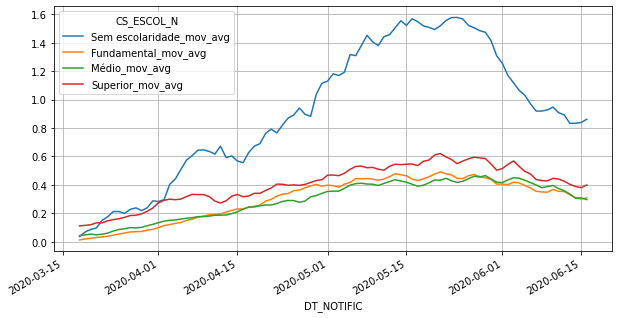

In [20]:
dffinal.plot(kind='line', y= mov_avg_columns, figsize=(10,5))
plt.grid()
plt.savefig('../graficos/escol_normalizado_mediamovel_todas.svg', dpi=300)
plt.savefig('../graficos/escol_normalizado_mediamovel_todas.png', dpi=300)

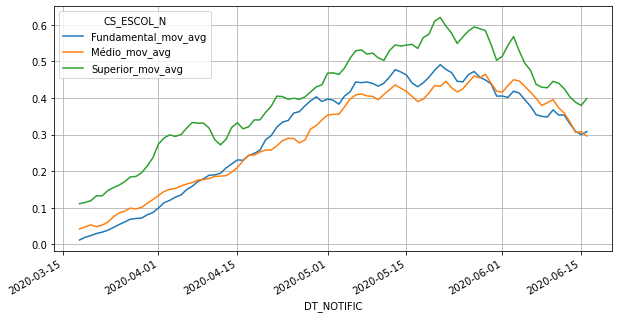

In [21]:
algumas_col = mov_avg_columns.copy()
algumas_col.remove('Sem escolaridade_mov_avg')
dffinal.plot(kind='line', y= algumas_col, figsize=(10,5))
plt.grid()
plt.savefig('../graficos/escol_normalizado_mediamovel_algumas.svg', dpi=300)
plt.savefig('../graficos/escol_normalizado_mediamovel_algumas.png', dpi=300)